# Stats, Plots + Prediction Demo

## Imports and setup

In [131]:
# Imports
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn
sns.set_palette('pastel')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.metrics import ConfusionMatrix
from scipy.stats import ttest_1samp, ttest_rel, ttest_ind

from NLP_Functions import *

In [2]:
# Importing the dataset (15k sample)
df = pd.read_json('Datasets/comments_processed_15ksample.json')
df.drop('Target_NPS', axis = 1, inplace = True)  # dropping this column as I won't use it
df.head()

,Title,Platform,Userscore,Comment,Username,Target,Comments_Processed
0,Super Smash Bros. for Wii U,WiiU,9,"This game is amazing, improves in every aspect...",Zin_49,Positive,"[game, amaz, improv, everi, aspect, previou, s..."
1,Zero Escape: Zero Time Dilemma,3DS,8,A bunch of bootleg robotic versions of the mai...,Techbane,Negative,"[bunch, bootleg, robot, version, main, charact..."
2,Metro: Last Light,PC,6,I liked the original this is some innovation b...,gstiker5,Negative,"[like, origin, innov, silent, main, charact, e..."
3,PlanetSide 2,PC,5,Planetside 2 has battles of epic scale and de...,NasseSeta,Negative,"[planetsid, battl, epic, scale, decent, gfx, g..."
4,Diablo III,PC,1,Game looks good and overall i like the graphic...,JamesLFranco,Negative,"[game, look, good, overal, like, graphic, game..."


In [127]:
df['Target'].value_counts()

Positive    8724
Negative    6276
Name: Target, dtype: int64

## Loading the saved model and most_common words

In [93]:
# Loading the trained model on these 15k samples
classifier_f = open('Logistic_Regression_15k.pickle', 'rb')
classifier = pickle.load(classifier_f)
classifier_f.close()

# Loading the 10k most_common words
most_common_f = open('10kmost_common_15ksample.pickle', 'rb')
most_common = pickle.load(most_common_f)
most_common_f.close()

## Initializing variables to get a prediction's list

In [4]:
# Note to self: should've exported this matrix as well

# Building the features and making the matrix
matrix = make_matrix(df['Comment'], df['Target'], most_common)

# Defining the size to use for the training and testing
size = int(len(matrix) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set = matrix[size:]
testing_set = matrix[:size]

In [5]:
# Checking the model's accuracy again
print('Logistic Regression accuracy:', str(round(nltk.classify.accuracy(classifier, testing_set) * 100, 2)) + '%')

Logistic Regression accuracy: 79.0%


In [6]:
# Extracting the testing_set labels to compare with the model's prediction
test_labels = [testing_set[i][1] for i in range(len(testing_set))]
print(test_labels.count('Positive'))  # 1748
print(test_labels.count('Negative'))  # 1252

1748
1252


In [7]:
# Getting the model's predictions
pred_list = [classifier.classify(testing_set[i][0]) for i in range(len(testing_set))]
print(pred_list.count('Positive'))  # 1802
print(pred_list.count('Negative'))  # 1198

1802
1198


## Confusion Matrix

In [132]:
# Unpacking the references (Positive or Negative) of the testing set to use for the confusion matrix
ref = [testing_set[i][1] for i in range(len(testing_set))]  # pos: xx | neg: xx

# List of predictions ran above
tagged = pred_list

# The actual confusion matrix
cm = ConfusionMatrix(ref, tagged)

print(cm)
cm

labels = set('Positive Negative'.split())

true_positives = Counter()
false_negatives = Counter()
false_positives = Counter()

for i in labels:
    for j in labels:
        if i == j:
            true_positives[i] += cm[i, j]
        else:
            false_negatives[i] += cm[i, j]
            false_positives[j] += cm[i, j]

# This seems to be the best model as the accuracy already predicted
print('TP + TN:', sum(true_positives.values()), true_positives)
print('FP + FN:', sum(false_positives.values()), false_positives)

         |    N    P |
         |    e    o |
         |    g    s |
         |    a    i |
         |    t    t |
         |    i    i |
         |    v    v |
         |    e    e |
---------+-----------+
Negative | <910> 342 |
Positive |  288<1460>|
---------+-----------+
(row = reference; col = test)

TP + TN: 2370 Counter({'Positive': 1460, 'Negative': 910})
FP + FN: 630 Counter({'Positive': 342, 'Negative': 288})


## Plots

### Actual vs Predicted Labels Comparisson

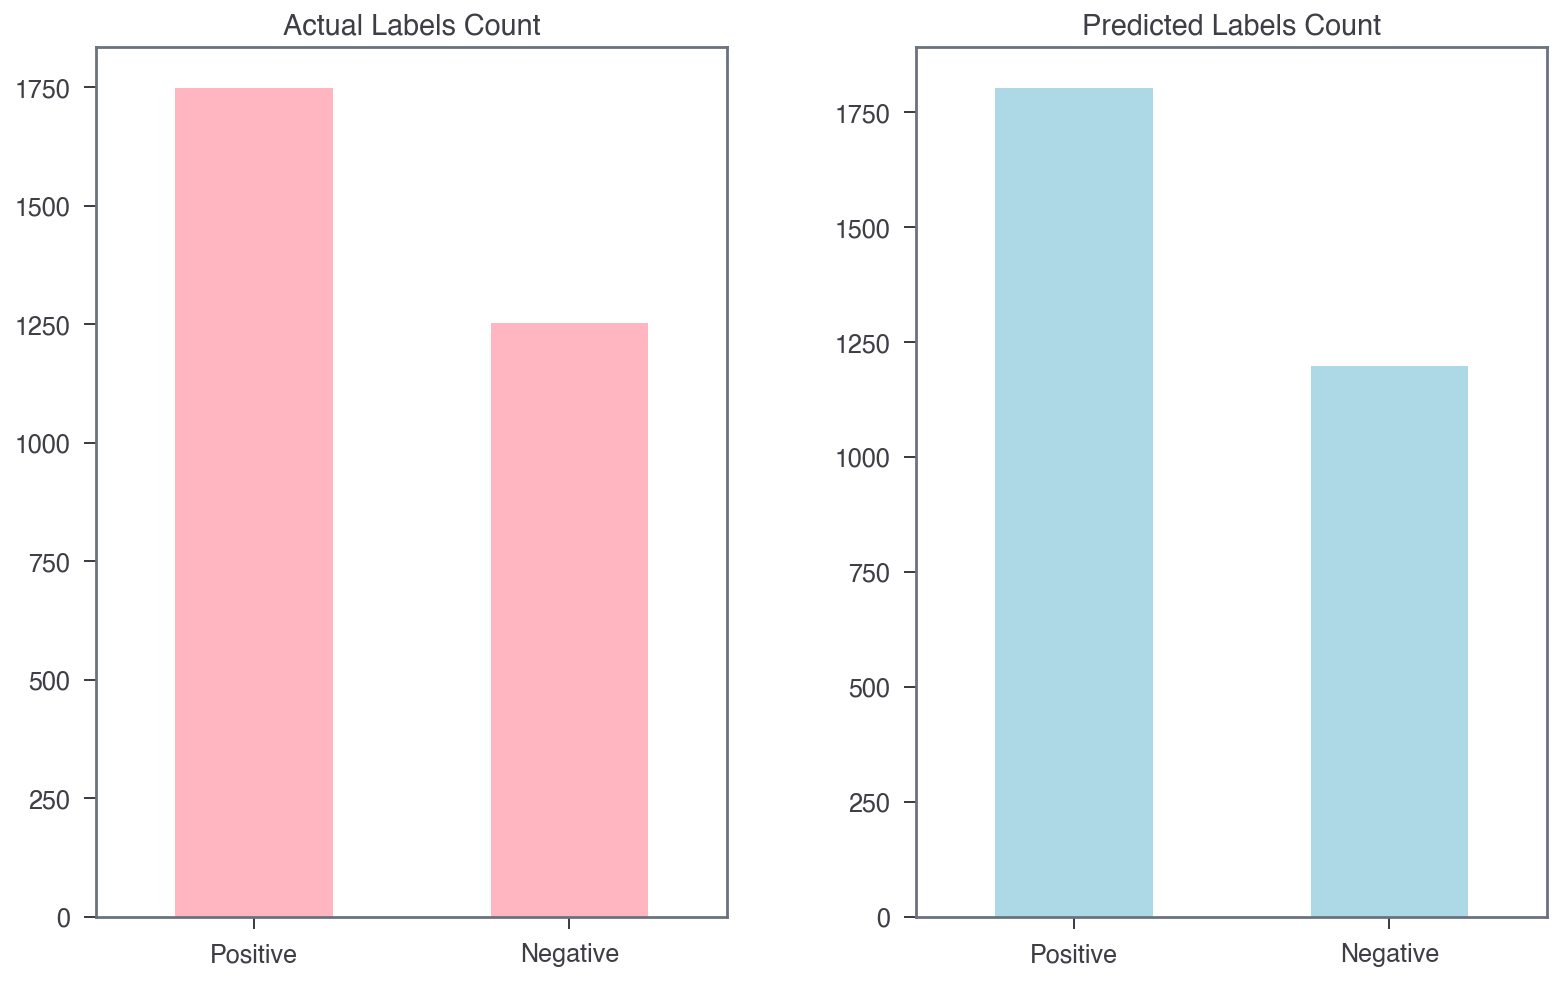

In [25]:
actual_vs_preds_df = pd.DataFrame({'Actual': test_labels, 'Predictions': pred_list})
actual_vs_preds_df

fig, axs = plt.subplots(1, 2, figsize = (13, 8))
plt.subplots_adjust(wspace = 0.3)

actual_vs_preds_df['Actual'].value_counts().plot(kind = 'bar', rot = 0, ax = axs[0], color = 'lightpink')
axs[0].set_title('Actual Labels Count')
#axs[0].set_ylabel('Count')

actual_vs_preds_df['Predictions'].value_counts().plot(kind = 'bar', rot = 0, ax = axs[1], color = 'lightblue')
#axs[1].set_ylabel('Count')
axs[1].set_title('Predicted Labels Count');

### T-Test Between Actual vs Predicted Labels

In [40]:
# Converting the labels to binary so the test can work
actual_vs_preds_df['Actual_B'] = np.where((actual_vs_preds_df['Actual'] == 'Positive'), 1, 0)
actual_vs_preds_df['Predictions_B'] = np.where((actual_vs_preds_df['Predictions'] == 'Positive'), 1, 0)

# T-TEST Between Actual vs Predicted
## We can reject the H0 that their means are equal, as 0.03 < 0.05
print(ttest_rel(actual_vs_preds_df['Actual_B'], actual_vs_preds_df['Predictions_B']))

#print(1748 / 3000)
#print(1802 / 3000)

Ttest_relResult(statistic=-2.152714204613889, pvalue=0.03142068031000951)


In [24]:
# Just checking if it all worked ok
print(actual_vs_preds_df['Actual_B'].value_counts(), '\n')
print(actual_vs_preds_df['Predictions_B'].value_counts())

1    1748
0    1252
Name: Actual_B, dtype: int64 

1    1802
0    1198
Name: Predictions_B, dtype: int64


In [9]:
print(actual_vs_preds_df['Actual'].value_counts(), '\n')
print(actual_vs_preds_df['Predictions'].value_counts(), '\n')

Positive    1748
Negative    1252
Name: Actual, dtype: int64 

Positive    1802
Negative    1198
Name: Predictions, dtype: int64 



### Most Common Words

In [14]:
# Extracting the words and their counts from the most_common list of tuples and turning it into a DF to plot
most_common_words = [x for x, y in most_common]
most_common_counts = [y for x, y in most_common]

words_df = pd.DataFrame({'Words': most_common_words, 'Count': most_common_counts})
words_df

,Words,Count
0,game,62369
1,play,16498
2,like,11873
3,one,9181
4,stori,8506
...,...,...
9995,wic,4
9996,cuento,4
9997,sitio,4
9998,mientra,4


### Top 10 Most Common Words

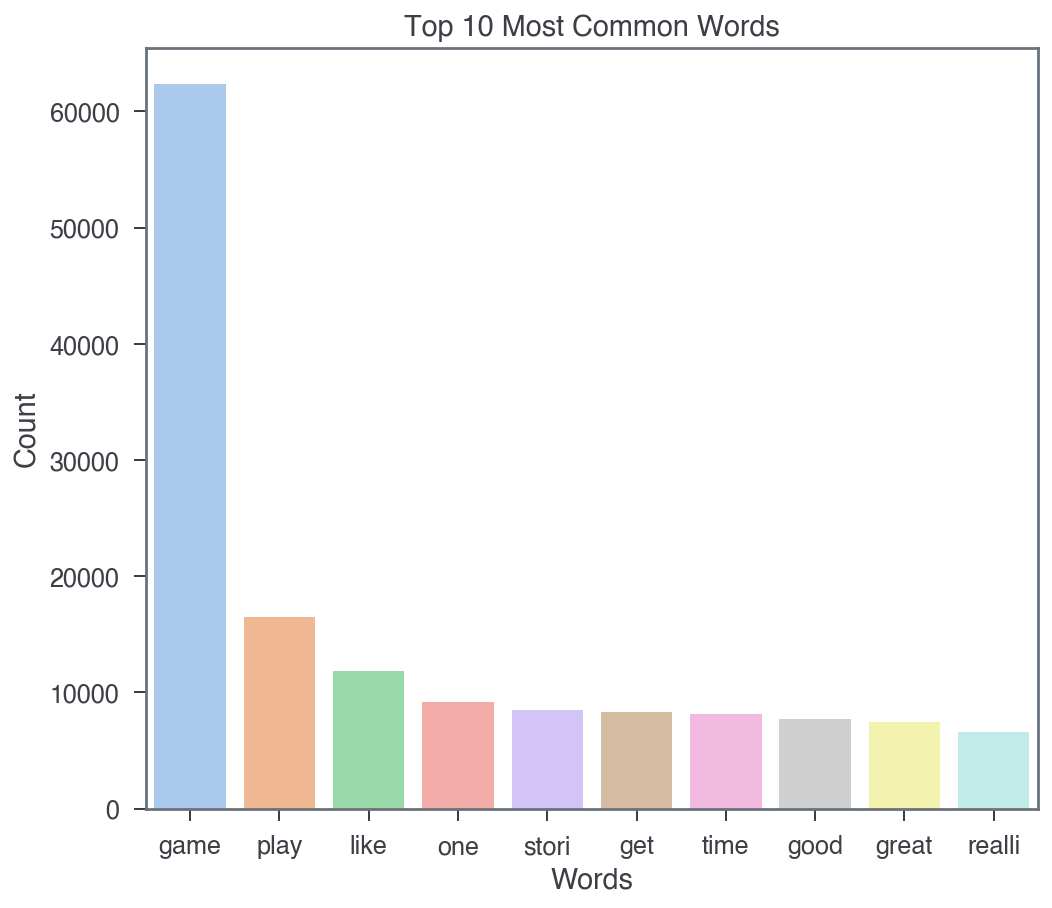

In [126]:
# Plotting the top 10 most common words
plt.title('Top 10 Most Common Words')
sns.barplot(x = 'Words', y = 'Count', data = words_df[:10]);

### Average Userscore Distribution

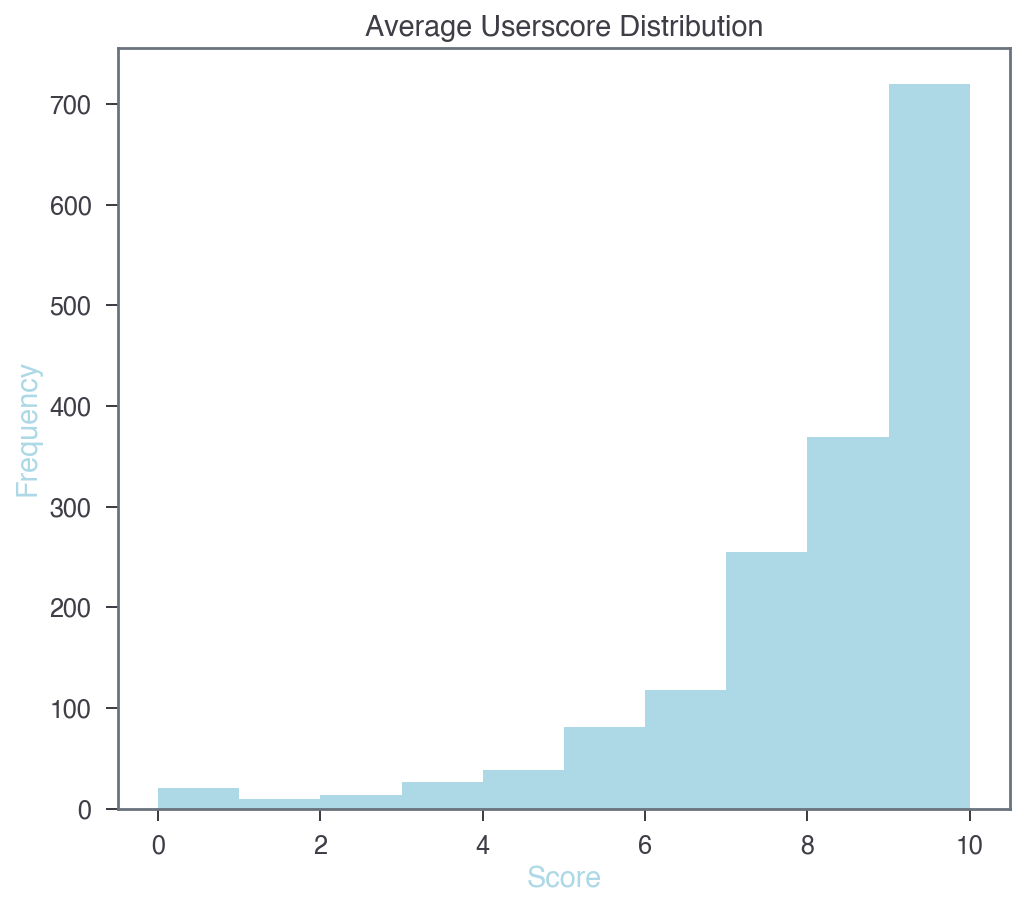

In [18]:
# Getting the avg_scores via groupby
avg_scores = df.groupby('Title', as_index = False).mean()
avg_scores['Userscore'] = avg_scores['Userscore'].apply(lambda x: round(x, 2))  # just rounding up to 2 dec. places

# Plotting
avg_scores.hist(color = 'lightblue', grid = False)
plt.ylabel('Frequency', color = 'lightblue')
plt.xlabel('Score', color = 'lightblue')
plt.title('Average Userscore Distribution');

In [94]:
# Simple prediction function that will be applied to the DF
def simple_pred(text):
    prediction = find_features(text, most_common)
    return classifier.classify(prediction)

# Don't know if it is interesting doing this or not, since the model trained on 80% of this data...
#df['Predictions'] = df['Comment'].apply(simple_pred)  # could've done in a single line with lambda, but whatever

In [161]:
df[3000:]

,Title,Platform,Userscore,Comment,Username,Target,Predictions
3000,The Sly Collection,PlayStation3,4,the first game 6/10the second game 3/10the thi...,Inuit_Dude,Negative,Negative
3001,Sid Meier's Civilization V,PC,10,I bought it for 75% off and I also have an ext...,Xsonic,Positive,Positive
3002,BioShock Infinite,PC,9,What can I say about this game that hasn't alr...,saucyninja007,Positive,Positive
3003,Call of Duty: Black Ops II,Xbox360,9,Black Ops 2 is a very enjoyable game that is f...,gingerclown,Positive,Negative
3004,Guild Wars,PC,9,Amazing. I have been playing Guild Wars since...,PhilipBS,Positive,Positive
...,...,...,...,...,...,...,...
14995,Halo: Reach,Xbox360,9,"Halo is far superior to it's competition, alwa...",IcyGames,Positive,Positive
14996,Uncharted 4: A Thief's End,PlayStation4,10,A Great Game even includes a Crash Bandicoot M...,Daxterman20,Positive,Positive
14997,Cuphead,XboxOne,10,Easily one of the best games of the year with ...,simsy,Positive,Positive
14998,The Elder Scrolls III: Morrowind,PC,8,This game would easily be 10 out of 10. I've p...,cimerians,Negative,Positive


In [136]:
print(df.Target.value_counts())
print(df.Predictions.value_counts())

Positive    8724
Negative    6276
Name: Target, dtype: int64
Positive    9061
Negative    5939
Name: Predictions, dtype: int64


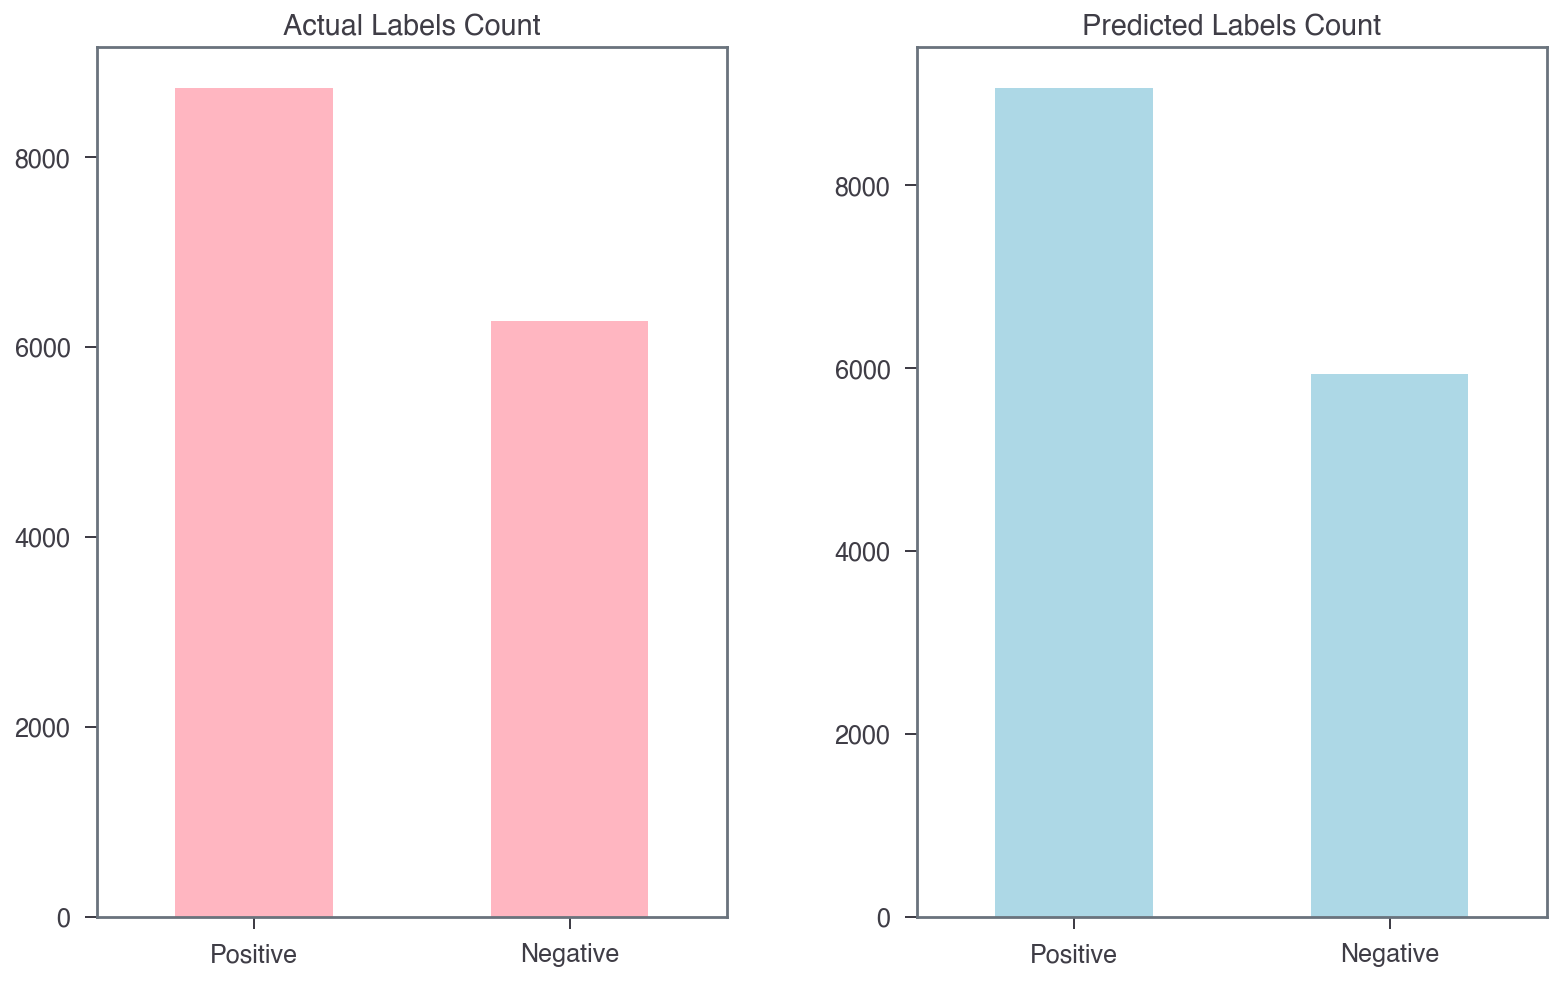

In [206]:
# Same plot as the previous one, but this time ran on the whole DF
fig, axs = plt.subplots(1, 2, figsize = (13, 8))
plt.subplots_adjust(wspace = 0.3)

df['Target'].value_counts().plot(kind = 'bar', rot = 0, ax = axs[0], color = 'lightpink')
axs[0].set_title('Actual Labels Count')

df['Predictions'].value_counts().plot(kind = 'bar', rot = 0, ax = axs[1], color = 'lightblue')
axs[1].set_title('Predicted Labels Count');

## Predictions Function

In [179]:
# Improved function to make the prediction look fancier :D
def predictor(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    
    prediction = find_features(text, most_common)
    
    print('Text input:', text, '\n')
    
    print('\nAfter all my intensive training, I evaluate this input as:')
    
    if (scores['neg'] > scores['pos']) and (classifier.classify(prediction) == 'Positive'):
        return 'Negative'
    else:
        return classifier.classify(prediction)


predictor('I think Ironhack is a good company. They have taught us many things in such a small amount of time.\
 However, I think they should increase the time spent teaching ML/Deep Learning/NLP.')

Text input: I think Ironhack is a good company. They have taught us many things in such a small amount of time. However, I think they should increase the time spent teaching ML/Deep Learning/NLP. 


After all my intensive training, I evaluate this input as:


'Positive'